# 1) Policy evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gridworld import GridWorld1
import gridrender as gui

In [2]:
env = GridWorld1

### Starting state distribution estimator

We estimate the starting state distribution $\mu_{0}$ through its empirical pmf following :

$$ \hat{\mu}_{0}(s) = \frac{1}{N}\sum_{i=1}^{N}\mathbb{1}_{\{x_{i}=s\}}\quad \forall s\in\mathcal{S}$$

where $(x_{1}, ..., x_{N})$ are randomly drawn with the `reset` method.

In [3]:
def starting_state_distribution(env, n_iter):
    distribution = np.zeros(env.n_states)
    for i in range(n_iter):
        starting_state = env.reset()
        distribution[starting_state] += 1.
    distribution = distribution/np.sum(distribution)
    return distribution

In order to set an appropriate value for $N$, we draw 3 simulations of the pmf estimator in parallel. At each step we compute the pairwise uniform distances and plot their evolutions along the number of iterations in order to identify a suitable threshold at which we shall set $N$

In [4]:
nr_concurrent = 3
max_iter = 1000
distributions = np.zeros((nr_concurrent, env.n_states))
mutual_distance = np.zeros((nr_concurrent, nr_concurrent-1, max_iter))

for n_iter in range(1,max_iter):
    for i in range(nr_concurrent):
        distributions[i] = starting_state_distribution(env, n_iter)
    for i, dist1 in enumerate(distributions):
        foo = np.delete(distributions, i, axis=0)
        for k, dist2 in enumerate(foo):
            distance = np.linalg.norm(dist1-dist2, ord=np.inf)
            mutual_distance[i,k,n_iter] = np.linalg.norm(dist1-dist2, ord=np.inf)       

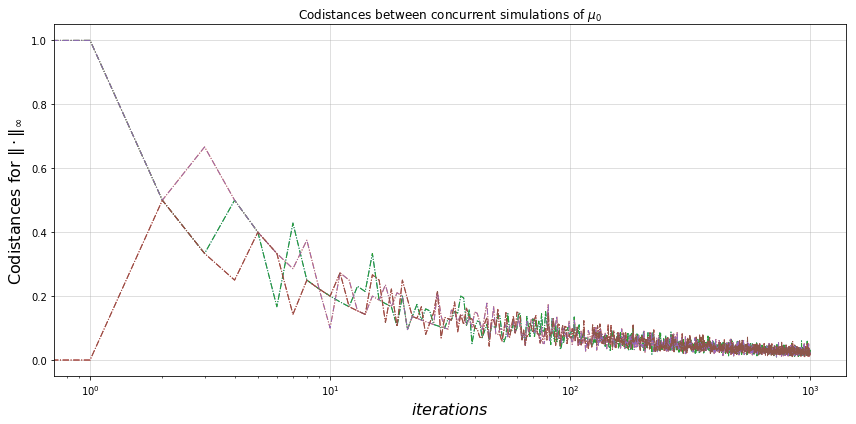

In [39]:
fig, ax = plt.subplots(figsize=(12,6))

for y in mutual_distance.reshape(6,max_iter):
    ax.plot(range(max_iter), y, '-.', linewidth=1)
ax.set_xlabel(r"$iterations$", size=16)
ax.set_ylabel(r"Codistances for $\|\!|\cdot\|\!|_{\infty}$", size=16)
ax.set_xscale('log')
ax.grid(alpha=0.5)
ax.set_title("Codistances between concurrent simulations of $\mu_{0}$")
plt.tight_layout()

There doesn't seem to be any significative improvement for $N\geq300$, this shall be our number of iteration for the estimation of the starting state distribution $\mu_{0}$

---
As $J_{n}$ and $J^{\pi}$ are given by similar formulas, we will implement a single function `J` for both

$$J_{n} = \mathbb{E}_{X\sim\mu_{0}}\left[V_{n}(X)\right] \enspace\text{and}\enspace J^{\pi} = \mathbb{E}_{X\sim\mu_{0}}\left[V^{\pi}(X)\right]$$

In [4]:
def J(value_vector, distribution):
    return np.inner(value_vector, distribution)

### MC implementation

In [5]:
DELTA = 0.05  # 0.05 close to infinite horizon
RMAX = 1      # reward bounded by 1

In [6]:
def estimate_value_MC(env, nr_episodes, Rmax=RMAX, delta=DELTA):
    
    Tmax = -np.log(delta/Rmax)/(1-env.gamma)
    N = np.zeros(env.n_states)
    value_monte_carlo = np.zeros(env.n_states)

    for episode in range(nr_episodes):
        # take random initial state
        initial_state = env.reset()
        # increment counter of episodes starting from this initial state
        N[initial_state] += 1

        # initialize loop variables
        next_state = initial_state
        t = 0
        absorb = False

        while not absorb and t < Tmax:
            t += 1

            # if "right" action avalaible
            if 0 in env.state_actions[next_state]:
                next_state, reward, absorb = env.step(next_state, 0)
            # else, "up" action
            else :
                next_state, reward, absorb = env.step(next_state, 3)

            # add reward
            value_monte_carlo[initial_state] += env.gamma**(t-1)*reward


    # average episodic values by episodes counter by initial state
    try :
        value_monte_carlo = value_monte_carlo/N
        return value_monte_carlo
    except ZeroDivisionError:
        raise ZeroDivisionError("Some states have never been visited as initial state, try to raise the number of episodes")

### Execution

In [8]:
mu_0 = starting_state_distribution(env, n_iter=300)
V_pi = np.array([0.877, 0.928, 0.988, 0., 0.671, -0.994, 0., -0.828, -0.877, -0.934, -0.994])
max_nr_episodes = 1000

In [9]:
J_pi = J(V_pi, mu_0)
diff_J = []

for nr_episodes in range(1, max_nr_episodes):
    value_monte_carlo = estimate_value_MC(env, nr_episodes)
    diff_J += [J(value_monte_carlo, mu_0)-J_pi]

/Users/dieze/anaconda/envs/rl_env/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


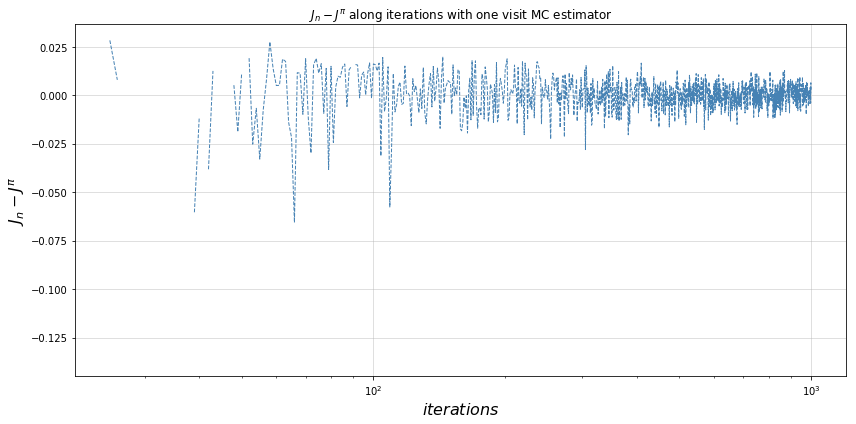

In [17]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(range(1,max_nr_episodes), diff_J, '--', linewidth=1, color="steelblue")
ax.set_xlabel(r"$iterations$", size=16)
ax.set_ylabel(r"$J_{n}-J^{\pi}$", size=16)
ax.set_xscale('log')
ax.grid(alpha=0.5)
ax.set_title("$J_{n}-J^{\pi}$ along iterations with one visit MC estimator")
plt.tight_layout()